In [104]:
from torch import nn, tensor, optim
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import torch.nn.functional as F
import torch

import nltk
from nltk.corpus import stopwords, wordnet

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import confusion_matrix

!pip install transformers
from transformers import BertModel
from transformers import BertTokenizer

!pip install tweet-preprocessor
import preprocessor as p

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import time

import string
import random

In [78]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [79]:
data = pd.read_csv('../input/sentiment/sentiment_final.csv')

In [80]:
def is_all_letter(word):
    
    for char in word:
        if char not in ' qwertyuiopasdfghjklzxcvbnm':
            return False
        
    return True


def remove_characters(str_, chars):
    
    for char in chars:
        str_ = str_.replace(char, '')
        
    return str_


def get_synonyms(word):
    
    synonyms = set()
    
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)


def generate_sentence(text, n=2):
    
    new_text = remove_characters(text, string.punctuation)
    word_set = set([word for word in new_text.split() if len(word) > 3 and is_all_letter(word.lower())])
    selected_words = random.sample(list(word_set), min(n, len(word_set)))
    for word in selected_words:
        
        synonyms = get_synonyms(word)
        if len(synonyms) != 0:
        
            new_word = random.sample(synonyms, 1)[0]
            text = text.replace(word, new_word)
        
    return text

In [81]:
def split_data(data):
    
    neg_id = data.index[data['sentiment'] == 'Negative'].tolist()
    pos_id = data.index[data['sentiment'] == 'Positive'].tolist()
    
    neg_train_id, neg_test_id, _, _ = train_test_split(neg_id, neg_id, test_size=0.3)
    neg_test_id, neg_valid_id, _, _ = train_test_split(neg_test_id, neg_test_id, test_size=1/3)
    
    pos_train_id, pos_test_id, _, _ = train_test_split(pos_id, pos_id, test_size=0.3)
    pos_test_id, pos_valid_id, _, _ = train_test_split(pos_test_id, pos_test_id, test_size=1/3)
    
    neg_train_id.extend(pos_train_id)
    neg_test_id.extend(pos_test_id)
    neg_valid_id.extend(pos_valid_id)
    
    train = data.iloc[neg_train_id].sample(frac=1)
    test = data.iloc[neg_test_id].sample(frac=1)
    valid = data.iloc[neg_valid_id].sample(frac=1)
    
    return train, test, valid

In [82]:
train, test, valid = split_data(data)
print(train.shape, test.shape, valid.shape)

(7510, 2) (2145, 2) (1074, 2)


In [83]:
train.groupby('sentiment').count()

,text
sentiment,
Negative,5945
Positive,1565


In [84]:
neg_id = train.index[train['sentiment'] == 'Negative'].tolist()
neg_id = np.random.choice(neg_id, 1000, replace=False)
train = train.drop(neg_id)

In [85]:
train.groupby('sentiment').count()

,text
sentiment,
Negative,4945
Positive,1565


In [86]:
n = 4945 - 1565
samples_for_sr = train.loc[train['sentiment'] == 'Positive'].sample(n=n, axis=0, replace=True)
samples_for_sr['text'] = samples_for_sr['text'].apply(lambda tweet: generate_sentence(tweet))

train = train.append(samples_for_sr, ignore_index=True)
train = train.sample(frac=1)
labels = train['sentiment'].values
np.unique(labels, return_counts=True)

(array(['Negative', 'Positive'], dtype=object), array([4945, 4945]))

In [87]:
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.EMOJI, p.OPT.HASHTAG)

def pre_processing(data):
    
    data['text'] = data['text'].apply(lambda text: text.lower())
    
    data['text'] = data['text'].apply(lambda tweet: p.clean(tweet))
    data['text'] = data['text'].apply(lambda tweet: remove_characters(tweet, string.punctuation))
    
    stop_words = set(stopwords.words('english'))
    data['text'] = data['text'].apply(
        lambda tweet: " ".join([word for word in tweet.split() if word not in stop_words])
    )
    
    return data

In [88]:
train = pre_processing(train)
test = pre_processing(test)
valid = pre_processing(valid)

In [89]:
train['sentiment'] = train['sentiment'].apply(lambda sent: 1 if sent == 'Negative' else 0)
test['sentiment'] = test['sentiment'].apply(lambda sent: 1 if sent == 'Negative' else 0)
valid['sentiment'] = valid['sentiment'].apply(lambda sent: 1 if sent == 'Negative' else 0)

In [90]:
x_train, y_train = train['text'], train['sentiment']
x_test, y_test = test['text'], test['sentiment']
x_valid, y_valid = valid['text'], valid['sentiment']

In [91]:
print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

(2145,) (2145,)
(1074,) (1074,)


In [92]:
class TweetClassifier(nn.Module):
    
    def __init__(self, hidden_dim, seq_len, n_lsmt_layers, output_dim, finetune=False):
        
        super(TweetClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_lsmt_layers

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        if not finetune:
            for p in self.bert.parameters():
                p.requires_grad = False

        self.lstm = nn.LSTM(768, hidden_dim, n_lsmt_layers, batch_first=True, dropout=0.3)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim*seq_len, output_dim),
            nn.Sigmoid()
        )
        
    def forward(self, seq, mask, hidden, seq_lens=None, eval_=False):

        seq_out, pooled_out = self.bert(input_ids=seq, attention_mask=mask, return_dict=False)
        lstm_out, hidden = self.lstm(seq_out, hidden)
        lstm_out = lstm_out.reshape(seq.shape[0], -1)
        out = self.classifier(lstm_out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                    weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        
        return hidden

In [93]:
def generate_x_y(x_, y_, max_len=100):

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    x, y, mask = [], [], []
    for i, (sample, label) in enumerate(zip(x_, y_)):

        tokens = ['[CLS]'] + tokenizer.tokenize(sample) + ['[SEP]']

        if len(tokens) < max_len:
            tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
        else:
            tokens = tokens[:max_len-1] + ['[SEP]']

        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        sample_mask = [1 if token != '[PAD]' else 0 for token in tokens]

        x.append(token_ids)
        mask.append(sample_mask)
        y.append(label)

    return torch.tensor(x), torch.tensor(y), torch.tensor(mask)

In [94]:
x_train, y_train, mask_train = generate_x_y(x_train, y_train)
x_test, y_test, mask_test = generate_x_y(x_test, y_test)
x_valid, y_valid, mask_valid = generate_x_y(x_valid, y_valid)

In [95]:
print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

torch.Size([2145, 100]) torch.Size([2145])
torch.Size([1074, 100]) torch.Size([1074])


In [96]:
import numpy as np
def generate_batches(x, y, mask, batch_size=128):
    
    indices = [i for i in range(len(x))]
    
    start = 0
    while start+batch_size <= len(x):
        batch_indices = indices[start:start+batch_size]
        yield x[batch_indices], y[batch_indices], mask[batch_indices]
        start += batch_size
        
    if start < len(x):
        yield x[start:], y[start:], mask[start:]

In [97]:
def train(model, x_valid, y_valid, mask_valid, epochs=30, batch_size=128):
        
    losses, valid_losses = [], []
    accuracies, valid_accuracies = [], []
    batch_loss = None

    loss=nn.BCELoss()
    opt=optim.Adam(model.parameters(), lr=0.001)

    model.train()

    for epoch in range(epochs):
        
        start = time.time()
        
        epoch_loss, epoch_accuracy = [], []
        for x_batch, y_batch, mask_batch in generate_batches(x_train, y_train, mask_train, batch_size):

            hidden = model.init_hidden(len(x_batch))
            hidden = tuple([h.data for h in hidden])
            
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()
            mask_batch = mask_batch.cuda()

            model.zero_grad()

            y_pred, hidden = model(x_batch, mask_batch, hidden)

            y_pred = y_pred.cpu().to(torch.float64)
            y_batch = y_batch.cpu().to(torch.float64)
            batch_loss = loss(y_pred.view(-1), y_batch)
            batch_loss.backward()
            opt.step()

            epoch_loss.append(batch_loss.detach().numpy())
            y_pred = [1 if p > 0.5 else 0 for p in y_pred]
            epoch_accuracy.append(accuracy(y_pred, y_batch.detach().numpy()))
            
        losses.append(np.mean(epoch_loss))
        accuracies.append(np.mean(epoch_accuracy))

        print(f'============================== epoch {epoch}')
        print(f'train loss: {np.mean(epoch_loss)}, train acc: {np.mean(epoch_accuracy)}')
        
        model.eval()
        with torch.no_grad():
            
            epoch_loss, epoch_accuracy = [], []
            for x_batch, y_batch, mask_batch in generate_batches(x_valid, y_valid, mask_valid, batch_size):

                hidden = model.init_hidden(len(x_batch))
                hidden = tuple([h.data for h in hidden])

                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()
                mask_batch = mask_batch.cuda()

                y_pred, hidden = model(x_batch, mask_batch, hidden)

                y_pred = y_pred.cpu().to(torch.float64)
                y_batch = y_batch.cpu().to(torch.float64)
                batch_loss = loss(y_pred.view(-1), y_batch)

                epoch_loss.append(batch_loss.detach().numpy())
                y_pred = [1 if p > 0.5 else 0 for p in y_pred]
                epoch_accuracy.append(accuracy(y_pred, y_batch.detach().numpy()))
            
        valid_losses.append(np.mean(epoch_loss))
        valid_accuracies.append(np.mean(epoch_accuracy))
        
        print(f'valid loss: {np.mean(epoch_loss)}, valid acc: {np.mean(epoch_accuracy)}')
        print(f'passed time: {time.time() - start}')
        
        model.train()
        
    return losses, valid_losses, accuracies, valid_accuracies, model

In [98]:
lstm = TweetClassifier(200, 100, 2, 1)
lstm.cuda()

losses, valid_losses, accuracies, valid_accuracies, lstm = train(lstm, x_valid, y_valid, mask_valid)

============================== epoch 0
train loss: 0.5633952878183549, train acc: 0.703743636877828
valid loss: 0.4632380408924943, valid acc: 0.7760069444444445
passed time: 34.25047755241394
============================== epoch 1
train loss: 0.4817037546851651, train acc: 0.7672452394419306
valid loss: 0.4254815925714883, valid acc: 0.8000347222222222
passed time: 34.22671937942505
============================== epoch 2
train loss: 0.42883513176198906, train acc: 0.7980238970588235
valid loss: 0.4402333112237249, valid acc: 0.7975347222222222
passed time: 34.22999310493469
============================== epoch 3
train loss: 0.3782712062573561, train acc: 0.8284726150075414
valid loss: 0.4660044463789305, valid acc: 0.7987847222222223
passed time: 34.22919988632202
============================== epoch 4
train loss: 0.32359539757676764, train acc: 0.8606004901960784
valid loss: 0.5656175534198113, valid acc: 0.7765972222222222
passed time: 34.22058129310608
=============================

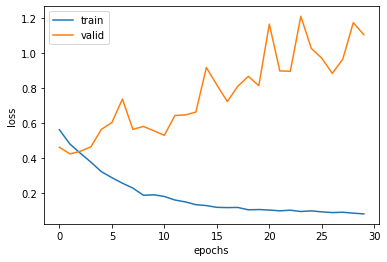

In [99]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

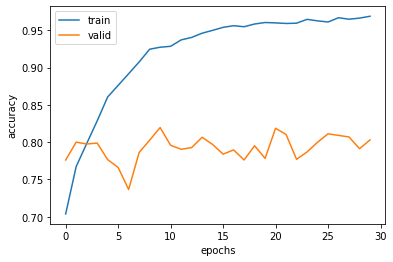

In [100]:
plt.plot(accuracies, label='train')
plt.plot(valid_accuracies, label='valid')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [101]:
preds = []
for x_batch, y_batch, mask_batch in generate_batches(x_test, y_test, mask_test, 128):
    
    hidden = lstm.init_hidden(len(x_batch))
    hidden = tuple([h.data for h in hidden])
    
    x_batch = x_batch.cuda()
    mask_batch = mask_batch.cuda()
    pred, _ = lstm(x_batch, mask_batch, hidden)
    preds.extend(pred.detach().cpu().numpy())
    
preds = np.array(preds)

In [102]:
preds = [1 if p > 0.5 else 0 for p in preds]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.50      0.60      0.55       447
           1       0.89      0.84      0.86      1698

    accuracy                           0.79      2145
   macro avg       0.69      0.72      0.70      2145
weighted avg       0.81      0.79      0.80      2145



<AxesSubplot:>

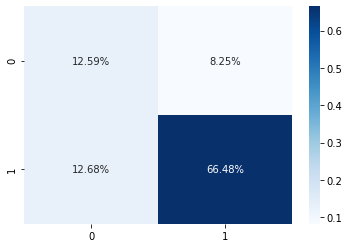

In [106]:
cf_matrix = confusion_matrix(y_test, preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [126]:
lstm = TweetClassifier(200, 100, 2, 1)
lstm.cuda()

losses, valid_losses, accuracies, valid_accuracies, lstm = train(lstm, x_valid, y_valid, mask_valid, epochs=10)

============================== epoch 0
train loss: 0.5677650680295906, train acc: 0.6976044023378583
valid loss: 0.44249191709115077, valid acc: 0.7934722222222222
passed time: 34.22986435890198
============================== epoch 1
train loss: 0.4815813829649268, train acc: 0.7723475207390649
valid loss: 0.42906993928463916, valid acc: 0.7987847222222223
passed time: 34.216800928115845
============================== epoch 2
train loss: 0.4276880268186383, train acc: 0.7943356429110106
valid loss: 0.4507999148647392, valid acc: 0.7765972222222222
passed time: 34.2211549282074
============================== epoch 3
train loss: 0.37913179803315433, train acc: 0.8314774226998491
valid loss: 0.4674600003115429, valid acc: 0.8026388888888889
passed time: 34.22246289253235
============================== epoch 4
train loss: 0.3378168163020874, train acc: 0.8535892722473605
valid loss: 0.5843642575143568, valid acc: 0.7643402777777778
passed time: 34.214043855667114
==========================

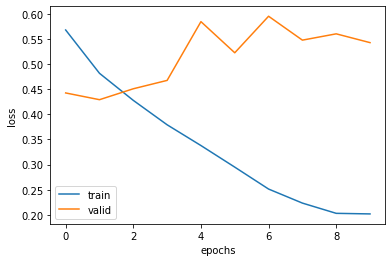

In [127]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

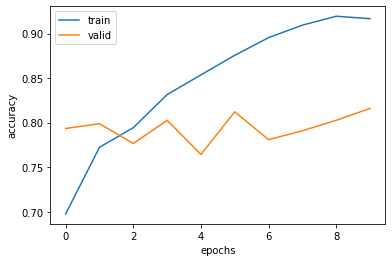

In [128]:
plt.plot(accuracies, label='train')
plt.plot(valid_accuracies, label='valid')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [129]:
preds = []
for x_batch, y_batch, mask_batch in generate_batches(x_test, y_test, mask_test, 128):
    
    hidden = lstm.init_hidden(len(x_batch))
    hidden = tuple([h.data for h in hidden])
    
    x_batch = x_batch.cuda()
    mask_batch = mask_batch.cuda()
    pred, _ = lstm(x_batch, mask_batch, hidden)
    preds.extend(pred.detach().cpu().numpy())
    
preds = np.array(preds)

In [130]:
preds = [1 if p > 0.5 else 0 for p in preds]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.57      0.52      0.54       447
           1       0.88      0.90      0.89      1698

    accuracy                           0.82      2145
   macro avg       0.72      0.71      0.71      2145
weighted avg       0.81      0.82      0.81      2145



<AxesSubplot:>

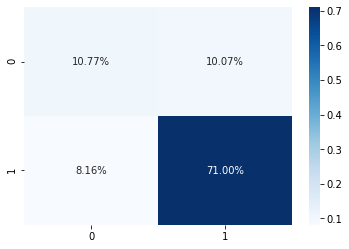

In [131]:
cf_matrix = confusion_matrix(y_test, preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')